# Dataset 과 Dataloader 

데이터셋을 가져오려고 할 때, pytorch에서는 `torch.util.data.DataLoader`와 `torch.util.data.Dataset` 두가지 메소드를 이용하여 쉽게 데이터셋을 불러오고 다룰 수 있다. 
- Dataset은 데이터셋을 불러올때, 여러가지 옵션을 설정해 주어 보다 간편하게 load하는 메소드이다. 
- Dataloader는 학습에 용이하게 하기위해 불러온 dataset을 순회가능한 객체(iterator)로 변환시켜 준다. 

### 1. Load Dataset 

이 튜토리얼에서는 `Fashion-MNIST`을 이용한다. 
학습용 이미지 60,000개와 테스트용 이미지 10,000개로 이루어져 있으며, grayscale의 28x28이미지로 10개의 class가 존재한다.  

dataset()메소드를 이용할 때, 아래 매개변수를 설정해 줘야 한다. 
- `root`      : 데이터셋이 저장되는 경로
- `train`     : 학습용 또는 테스트용 데이터셋에 대한 설정 
- `download`  : false 또는 true값을 입력하며 true일 경우, root에 데이터셋이 존재하지 않으면 다운로드 한다.
- `transform` : 데이터셋에 대한 transform에 대한 옵션을 설정한다. 

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # array로 구성된 데이터셋을 tensor로 변환하여 load 
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # test데이터셋이므로 false로 설정 
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/home/aiffel/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


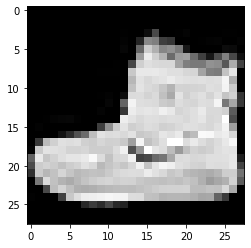

In [21]:

img=training_data[0][0]
plt.imshow(img.squeeze(),cmap='gray')

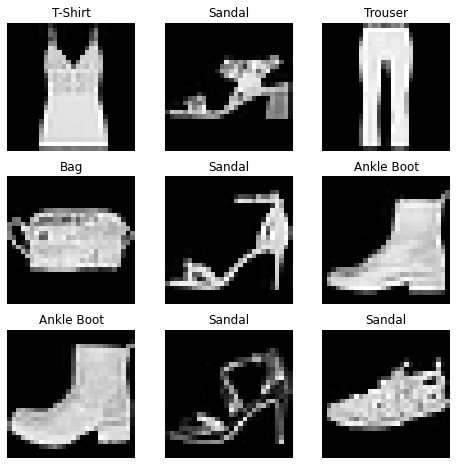

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 사용자 정의 데이터셋 

사용자 정의 데이터셋을 만들기 위해서는 세 가지 메소드가 반드시 필요하다.
- `__init__`
- `__len__`
- `__getitem__`

In [24]:
import os
import pandas as pd
from torchvision.io import read_image

# annotation_file  : load하고자 하는 label파일의 경로  
# img_dir : 이미지 데이터의 경로 


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path) # read_image()는 torchcvision의 메소드
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### DataLoader

모델을 학습하는 경우에 데이터들은 미니배치로 입력이 되고 매 에폭마다 데이터를 다시 섞어(shuffle) 과적합을 방지한다. 또한 python의 multiprocessing을 사용하여 데이터의 검색속도를 높이려 한다.   

pytorch의 dataloader는 이러한 기능을 추상화한 API로 데이터셋을 iterator로 이용 가능하게 한다. 


In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


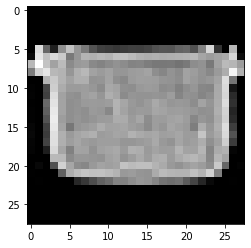

Label: 8


In [26]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")